In [ ]:
# !pip install fuzzywuzzy

In [ ]:
import pandas as pd
import re

from fuzzywuzzy import fuzz

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Labels pulled from the Common Voice Cr 20.0 tables.

# The age and gender labels are pre-categorized and do not require further processing.
age_labels = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies']
gender_labels = ['male_masculine', 'female_feminine', 'non-binary', 'transgender', 'do_not_wish_to_say']

# The accent labels were provided by the user and require further processing.
common_voice_accents = pd.read_csv('/content/drive/My Drive/MIDS/mp3_count_by_accent_for_common_voice.csv')
common_voice_accents.head()

,Accent,MP3_Count
0,United States English,435673
1,England English,150300
2,"India and South Asia (India, Pakistan, Sri Lanka)",108836
3,Canadian English,74732
4,Australian English,54827


In [ ]:
# For details on accent categories, refer to the document: https://docs.google.com/document/d/1i8AIa1-pm2HnQSn2aV_kiYyUUeWM9dSXJb9zYLGRqRM/edit?usp=sharing.
ACCENT_CATEGORIES = [
    'British Isles',
    'North America',
    'Oceania',
    'Sub-Saharan Africa',
    'South Africa and Southern Africa',
    'South Asia',
    'Southeast Asia',
    'East Asia',
    'Middle East and Central Asia',
    'Caribbean',
    'Latin America',
    'Eastern Europe',
    'Western Europe',
    'Scandinavia and Northern Europe',
    'Mediterranean'
]

category_keywords = {
    'British Isles': [
        'United Kingdom', 'England', 'Scotland', 'Wales', 'Northern Ireland', 'Ireland'
    ],
    'North America': [
        'United States', 'Canada'
    ],
    'Oceania': [
        'Australia', 'New Zealand', 'Papua New Guinea', 'Fiji', 'Samoa', 'Tonga', 'Vanuatu',
        'Solomon Islands', 'Kiribati', 'Tuvalu', 'Nauru', 'Marshall Islands', 'Palau', 'Micronesia',
        'Cook Islands', 'Niue', 'American Samoa', 'French Polynesia', 'New Caledonia', 'Wallis and Futuna'
    ],
    'Sub-Saharan Africa': [
        'Ghana', 'Nigeria', 'Kenya', 'Uganda', 'Tanzania', 'Zambia',
        'Malawi', 'Angola', 'Mozambique', 'Seychelles', 'Mauritius', 'Côte d\'Ivoire', 'Senegal', 'Cameroon', 'Mali',
        'Burkina Faso', 'Niger', 'Rwanda', 'Burundi', 'Chad', 'Central African Republic', 'Democratic Republic of the Congo',
        'Republic of the Congo', 'Togo', 'Benin', 'Comoros', 'Eritrea', 'South Sudan', 'Botswana', 'Gabon'
    ],
    'Southern Africa': [
        'South Africa', 'Namibia', 'Zimbabwe', 'Lesotho'
    ],
    'South Asia': [
        'India', 'Pakistan', 'Sri Lanka', 'Bangladesh', 'Nepal', 'Maldives', 'Bhutan'
    ],
    'Southeast Asia': [
        'Philippines', 'Indonesia', 'Thailand', 'Vietnam', 'Malaysia', 'Singapore', 'Myanmar',
        'Cambodia', 'Brunei', 'Laos', 'Timor-Leste'
    ],
    'East Asia': [
        'China', 'Japan', 'South Korea', 'North Korea', 'Mongolia', 'Taiwan', 'Hong Kong', 'Macau'
    ],
    'Middle East and Central Asia': [
        'Turkey', 'Iran', 'Iraq', 'Saudi Arabia', 'Syria', 'Jordan', 'Lebanon', 'Israel', 'Palestine',
        'Egypt', 'Kuwait', 'Bahrain', 'Qatar', 'United Arab Emirates', 'Oman', 'Yemen', 'Afghanistan',
        'Uzbekistan', 'Kazakhstan', 'Kyrgyzstan', 'Turkmenistan', 'Tajikistan', 'Azerbaijan', 'Armenia'
    ],
    'Caribbean': [
        'Jamaica', 'Trinidad and Tobago', 'Bahamas', 'Barbados', 'Haiti', 'Cuba', 'Dominican Republic',
        'Puerto Rico', 'Saint Lucia', 'Antigua and Barbuda', 'Saint Kitts and Nevis', 'Grenada',
        'Saint Vincent and the Grenadines', 'Belize', 'Bermuda', 'Cayman Islands'
    ],
    'Latin America': [
        'Argentina', 'Brazil', 'Colombia', 'Chile', 'Peru', 'Venezuela', 'Ecuador',
        'Bolivia', 'Paraguay', 'Uruguay', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua',
        'Costa Rica', 'Panama', 'Mexico'
    ],
    'Eastern Europe': [
        'Russia', 'Poland', 'Ukraine', 'Romania', 'Bulgaria', 'Serbia', 'Croatia', 'Slovenia', 'Moldova',
        'Slovakia', 'Czech Republic', 'Hungary', 'Albania', 'Bosnia and Herzegovina', 'North Macedonia',
        'Belarus', 'Georgia', 'Armenia', 'Kosovo'
    ],
    'Western Europe': [
        'France', 'Germany', 'Italy', 'Portugal', 'Netherlands', 'Belgium', 'Luxembourg',
        'Switzerland', 'Monaco', 'Austria', 'Liechtenstein', 'San Marino', 'Andorra', 'Spain'
    ],
    'Scandinavia and Northern Europe': [
        'Norway', 'Sweden', 'Finland', 'Denmark', 'Iceland', 'Estonia', 'Latvia', 'Lithuania'
    ],
    'Mediterranean': [
        'Greece', 'Turkey', 'Cyprus', 'Malta', 'Tunisia', 'Algeria', 'Morocco',
        'Egypt', 'Lebanon', 'Syria', 'Libya', 'Palestinian Territories', 'Spain'
    ]
}

In [ ]:
def categorize_accent_label(accent_label):
    matched_categories = []

    # Loop through accent categories to look for fuzzy matches.
    for category, countries in category_keywords.items():
        for country in countries:
            # Use fuzzy matching to calculate the similarity score.
            similarity_score = fuzz.partial_ratio(accent_label.lower(), country.lower())

            # If the similarity score is above the threshold, consider it a match.
            if similarity_score >= 90:
                matched_categories.append(category)
                break  # No need to check more countries in the current category.

    if len(matched_categories) > 1 and 'North America' in matched_categories:
        matched_categories.remove('North America')

    return matched_categories

In [ ]:
common_voice_accents['Assigned Categories'] = common_voice_accents['Accent'].apply(categorize_accent_label)
common_voice_accents.head()

,Accent,MP3_Count,Assigned Categories
0,United States English,435673,[North America]
1,England English,150300,[British Isles]
2,"India and South Asia (India, Pakistan, Sri Lanka)",108836,[South Asia]
3,Canadian English,74732,[]
4,Australian English,54827,[Oceania]


In [ ]:
# Let's take a look at the rows where more than one category was assigned.
common_voice_accents[common_voice_accents['Assigned Categories'].apply(lambda x: len(x) > 1)][['Accent', 'Assigned Categories']]
# It looks like these are people who have multiple accents (rather than an issue with the classifying logic).
# Therefore, we will filter out these rows from our final dataset.

,Accent,Assigned Categories
16,"England English,New Zealand English","[British Isles, Oceania]"
58,"United States English,Australian English,Engla...","[British Isles, Oceania]"
72,"India and South Asia (India, Pakistan, Sri Lan...","[South Asia, Southeast Asia]"
76,"England English,India and South Asia (India, P...","[British Isles, South Asia]"
94,"United States English,England English,India an...","[British Isles, South Asia]"
111,"United States English,England English,Brazilia...","[British Isles, Latin America]"
112,"England English,Malaysian English","[British Isles, Southeast Asia]"
122,"Romanian,Eastern European","[Middle East and Central Asia, Eastern Europe]"
131,"England English,Southern African (South Africa...","[British Isles, Southern Africa]"
150,"England English,India and South Asia (India, P...","[British Isles, South Asia]"


In [ ]:
common_voice_accents = common_voice_accents[common_voice_accents['Assigned Categories'].apply(lambda x: len(x) == 1)]
common_voice_accents['Assigned Category'] = common_voice_accents['Assigned Categories'].apply(lambda x: x[0])
common_voice_accents = common_voice_accents.drop(columns=['Assigned Categories'])
common_voice_accents.head()

<ipython-input-9-1371a3b8f3e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_voice_accents['Assigned Category'] = common_voice_accents['Assigned Categories'].apply(lambda x: x[0])


,Accent,MP3_Count,Assigned Category
0,United States English,435673,North America
1,England English,150300,British Isles
2,"India and South Asia (India, Pakistan, Sri Lanka)",108836,South Asia
4,Australian English,54827,Oceania
6,"Southern African (South Africa, Zimbabwe, Nami...",24654,Southern Africa


In [ ]:
grouped_df = common_voice_accents.groupby('Assigned Category')['MP3_Count'].sum().reset_index()
grouped_df = grouped_df.sort_values(by='MP3_Count', ascending=False)
grouped_df

,Assigned Category,MP3_Count
7,North America,445538
0,British Isles,159062
10,South Asia,109959
8,Oceania,69336
12,Southern Africa,25911
11,Southeast Asia,6218
2,East Asia,4709
1,Caribbean,855
14,Western Europe,496
3,Eastern Europe,465


# Visualizations

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the world shapefile
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip
world = gpd.read_file('ne_110m_admin_0_countries.shp')

--2025-03-17 22:25:30--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.218.133.105, 52.218.178.35, 52.218.181.99, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.218.133.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip.3’

ne_110m_admin_0_cou 100%[===================>] 209.94K  --.-KB/s    in 0.1s    

2025-03-17 22:25:31 (1.68 MB/s) - ‘ne_110m_admin_0_countries.zip.3’ saved [214976/214976]

Archive:  ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ne_110m_admin_0_countries.README.html  
replace ne_110m_admin_0_countries.VERSION.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: ne_110m_admin_0_countries.VERSION.txt  
replace ne_110m_admin_0_countries

In [ ]:
print(world['NAME'].unique())

['Fiji' 'Tanzania' 'W. Sahara' 'Canada' 'United States of America'
 'Kazakhstan' 'Uzbekistan' 'Papua New Guinea' 'Indonesia' 'Argentina'
 'Chile' 'Dem. Rep. Congo' 'Somalia' 'Kenya' 'Sudan' 'Chad' 'Haiti'
 'Dominican Rep.' 'Russia' 'Bahamas' 'Falkland Is.' 'Norway' 'Greenland'
 'Fr. S. Antarctic Lands' 'Timor-Leste' 'South Africa' 'Lesotho' 'Mexico'
 'Uruguay' 'Brazil' 'Bolivia' 'Peru' 'Colombia' 'Panama' 'Costa Rica'
 'Nicaragua' 'Honduras' 'El Salvador' 'Guatemala' 'Belize' 'Venezuela'
 'Guyana' 'Suriname' 'France' 'Ecuador' 'Puerto Rico' 'Jamaica' 'Cuba'
 'Zimbabwe' 'Botswana' 'Namibia' 'Senegal' 'Mali' 'Mauritania' 'Benin'
 'Niger' 'Nigeria' 'Cameroon' 'Togo' 'Ghana' "Côte d'Ivoire" 'Guinea'
 'Guinea-Bissau' 'Liberia' 'Sierra Leone' 'Burkina Faso'
 'Central African Rep.' 'Congo' 'Gabon' 'Eq. Guinea' 'Zambia' 'Malawi'
 'Mozambique' 'eSwatini' 'Angola' 'Burundi' 'Israel' 'Lebanon'
 'Madagascar' 'Palestine' 'Gambia' 'Tunisia' 'Algeria' 'Jordan'
 'United Arab Emirates' 'Qatar' 'Kuwait'

In [ ]:
regions = {
    'British Isles': ['United Kingdom', 'Ireland'],
    'North America': ['Canada', 'United States of America', 'Mexico', 'Puerto Rico'],
    'Oceania': ['Fiji', 'Papua New Guinea', 'Australia', 'New Zealand', 'Solomon Is.', 'New Caledonia', 'Vanuatu'],
    'Sub-Saharan Africa': ['Tanzania', 'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti', 'Zimbabwe',
                           'Botswana', 'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
                           'Togo', 'Ghana', 'Côte d\'Ivoire', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Sierra Leone',
                           'Burkina Faso', 'Central African Rep.', 'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi',
                           'Mozambique', 'eSwatini', 'Angola', 'Burundi', 'Madagascar', 'Gambia', 'Tunisia', 'Algeria',
                           'Uganda', 'Rwanda'],
    'South Africa and Southern Africa': ['South Africa', 'Lesotho', 'Eswatini (Swaziland)'],
    'South Asia': ['India', 'Bangladesh', 'Bhutan', 'Nepal', 'Pakistan', 'Afghanistan'],
    'Southeast Asia': ['Cambodia', 'Thailand', 'Laos', 'Myanmar', 'Vietnam', 'Philippines', 'Malaysia', 'Brunei',
                       'Timor-Leste', 'Singapore'],
    'East Asia': ['China', 'Taiwan', 'North Korea', 'South Korea', 'Japan'],
    'Middle East and Central Asia': ['Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Iran', 'Syria', 'Armenia', 'Azerbaijan',
                                     'Georgia', 'Iraq', 'Jordan', 'Lebanon', 'Israel', 'Palestine', 'Qatar', 'United Arab Emirates',
                                     'Kuwait', 'Oman', 'Yemen'],
    'Caribbean': ['Bahamas', 'Cuba', 'Jamaica', 'Dominican Rep.', 'Trinidad and Tobago', 'Haiti', 'Guyana', 'Suriname'],
    'Latin America': ['Argentina', 'Chile', 'Uruguay', 'Brazil', 'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica',
                      'Nicaragua', 'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela', 'Ecuador', 'Paraguay',
                      'French Guiana'],
    'Eastern Europe': ['Belarus', 'Ukraine', 'Moldova', 'Romania', 'Bulgaria', 'Serbia', 'North Macedonia', 'Montenegro',
                       'Kosovo', 'Bosnia and Herz.', 'Russia'],
    'Western Europe': ['France', 'Netherlands', 'Germany', 'Austria', 'Hungary', 'Luxembourg', 'Belgium', 'Switzerland',
                       'Spain', 'Portugal', 'Italy'],
    'Scandinavia and Northern Europe': ['Norway', 'Sweden', 'Denmark', 'Finland', 'Iceland', 'Estonia', 'Latvia', 'Lithuania',
                                        'Greenland'],
    'Mediterranean': ['Greece', 'Turkey', 'Cyprus', 'Malta', 'Egypt', 'Libya', 'Morocco'],
    'Other': ['Antarctica', 'Fr. S. Antarctic Lands', 'W. Sahara', 'Falkland Is.', 'N. Cyprus']
}

<ipython-input-61-ab7c37994fdc>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'British Isles' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  world.loc[world['NAME'].str.contains(country, case=False, na=False), 'region'] = region
<ipython-input-61-ab7c37994fdc>:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  world.loc[world['NAME'].str.contains(country, case=False, na=False), 'region'] = region


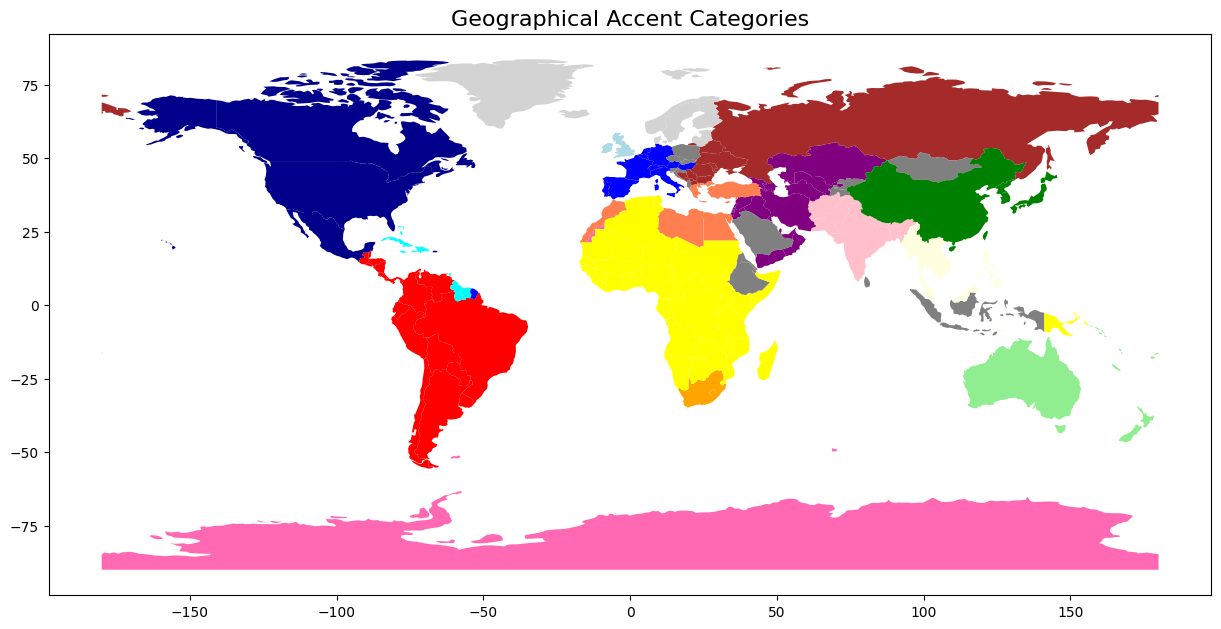

In [ ]:
# Add a column to the GeoDataFrame for region assignments
world['region'] = np.nan

for region, countries in regions.items():
    for country in countries:
        # Use .str.contains() for partial string matching to cover more cases
        world.loc[world['NAME'].str.contains(country, case=False, na=False), 'region'] = region

# Fill NaN values in 'region' with a default color (gray)
world['region'] = world['region'].fillna('gray')

# Create a color palette (one color for each region)
region_colors = {
    'British Isles': 'lightblue',
    'North America': 'darkblue',
    'Oceania': 'lightgreen',
    'Sub-Saharan Africa': 'yellow',
    'South Africa and Southern Africa': 'orange',
    'South Asia': 'pink',
    'Southeast Asia': 'lightyellow',
    'East Asia': 'green',
    'Middle East and Central Asia': 'purple',
    'Caribbean': 'cyan',
    'Latin America': 'red',
    'Eastern Europe': 'brown',
    'Western Europe': 'blue',
    'Scandinavia and Northern Europe': 'lightgrey',
    'Mediterranean': 'coral',
    'Other': 'hotpink',
    'gray': 'gray'  # Assign gray color explicitly for non-matching countries
}

# Plot the world map with regions colored
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color=world['region'].map(region_colors), legend=True)

# Add a title
plt.title('Geographical Accent Categories', fontsize=16)

# Show the plot
plt.show();